# Importing data from kaggle

Google drive must be activated in order to download the chest X-Ray data from kaggle.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from zipfile import ZipFile

# Use your kaggle config directory with your key.
os.environ["KAGGLE_CONFIG_DIR"] = "drive/MyDrive/master/kaggle"

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

zf = ZipFile('chest-xray-pneumonia.zip')
zf.extractall('chest-xray-pneumonia')
zf.close()
!ls
!rm chest-xray-pneumonia.zip
!ls chest-xray-pneumonia/chest_xray
!ls chest-xray-pneumonia/chest_xray/test/
!ls chest-xray-pneumonia/chest_xray/train
!ls chest-xray-pneumonia/chest_xray/val/

100% 2.29G/2.29G [01:51<00:00, 22.4MB/s]
100% 2.29G/2.29G [01:51<00:00, 22.2MB/s]
chest-xray-pneumonia  chest-xray-pneumonia.zip	drive  sample_data
chest_xray  __MACOSX  test  train  val
NORMAL	PNEUMONIA
NORMAL	PNEUMONIA
NORMAL	PNEUMONIA


# Importing necessary libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB3

# **Dataset creation**

Source: https://www.kaggle.com/code/uzumakibalu/chest-x-ray-pneumonia-cnn-transfer-learning

In [4]:
import glob

train_path = "./chest-xray-pneumonia/chest_xray/train"
test_path = "./chest-xray-pneumonia/chest_xray/test"
val_path = "./chest-xray-pneumonia/chest_xray/val"

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

val_normal = glob.glob(val_path+"/NORMAL/*.jpeg")
val_pneumonia = glob.glob(val_path+"/PNEUMONIA/*.jpeg")

train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['label'])
df_train['image_path'] = [x for x in train_list]

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['label'])
df_test['image_path'] = [x for x in test_list]

df_val = pd.DataFrame(np.concatenate([['Normal']*len(val_normal) , ['Pneumonia']*len(val_pneumonia)]), columns = ['label'])
df_val['image_path'] = [x for x in val_list]

In [5]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 300
BATCH_SIZE = 32

#rescaling is not necessary; as the model incorporates it as a layer: https://keras.io/api/applications/efficientnet/
train_datagen = ImageDataGenerator(zoom_range = 0.1,
                                   #rescale=1/255.,
                                   rotation_range = 0.1,
                                   horizontal_flip = True,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1)
val_datagen = ImageDataGenerator(
                                #rescale=1/255.
                                )

ds_train = train_datagen.flow_from_dataframe(df_train,
                                             x_col = 'image_path',
                                             y_col = 'label',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH_SIZE)

ds_val = val_datagen.flow_from_dataframe(df_val,
                                         x_col = 'image_path',
                                         y_col = 'label',
                                         target_size = (IMG_SIZE, IMG_SIZE),
                                         class_mode = 'binary',
                                         batch_size = 1)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                          x_col = 'image_path',
                                          y_col = 'label',
                                          target_size = (IMG_SIZE, IMG_SIZE),
                                          class_mode = 'binary',
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Found 5216 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


#**Defining the Model**

In [6]:
# EfficientNet needs 3 channel inputs, but it doesen't matter that most of our images have only one colour:
# https://towardsdatascience.com/transfer-learning-on-greyscale-images-how-to-fine-tune-pretrained-models-on-black-and-white-9a5150755c7a
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

model = EfficientNetB3(include_top=False,
                       input_tensor=inputs,
                       weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(units = 1, # Two outputs to predict 2 outomes
                       activation="sigmoid", #binary data
                       name="pred")(x)

# Compile
model = keras.Model(inputs, outputs, name="EfficientNet") # Nano library model object
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy", #output label binary
    metrics='binary_accuracy')

43941136/43941136 [==============================] - 3s 0us/step


In [7]:
# function for plotting the progress of our model
def plot_hist(hist):
    plt.plot(hist.history["binary_accuracy"])
    plt.plot(hist.history["val_binary_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

## Training


In [8]:
epochs = 15

hist = model.fit(
    ds_train,
    steps_per_epoch=ds_train.samples//ds_train.batch_size,
    epochs=epochs,
    validation_data=ds_val,
    validation_steps=ds_val.samples//ds_val.batch_size,
    verbose=1)

Epoch 1/15
163/163 [==============================] - 177s 980ms/step - loss: 0.2703 - binary_accuracy: 0.9172 - val_loss: 1.4398 - val_binary_accuracy: 0.5000
Epoch 2/15
163/163 [==============================] - 159s 975ms/step - loss: 0.2277 - binary_accuracy: 0.9367 - val_loss: 0.0550 - val_binary_accuracy: 1.0000
Epoch 3/15
163/163 [==============================] - 157s 961ms/step - loss: 0.2285 - binary_accuracy: 0.9381 - val_loss: 0.0155 - val_binary_accuracy: 1.0000
Epoch 4/15
163/163 [==============================] - 157s 965ms/step - loss: 0.2568 - binary_accuracy: 0.9383 - val_loss: 0.0117 - val_binary_accuracy: 1.0000
Epoch 5/15
163/163 [==============================] - 157s 965ms/step - loss: 0.2306 - binary_accuracy: 0.9390 - val_loss: 0.4065 - val_binary_accuracy: 0.8750
Epoch 6/15
163/163 [==============================] - 158s 969ms/step - loss: 0.1962 - binary_accuracy: 0.9490 - val_loss: 0.0329 - val_binary_accuracy: 1.0000
Epoch 7/15
163/163 [====================

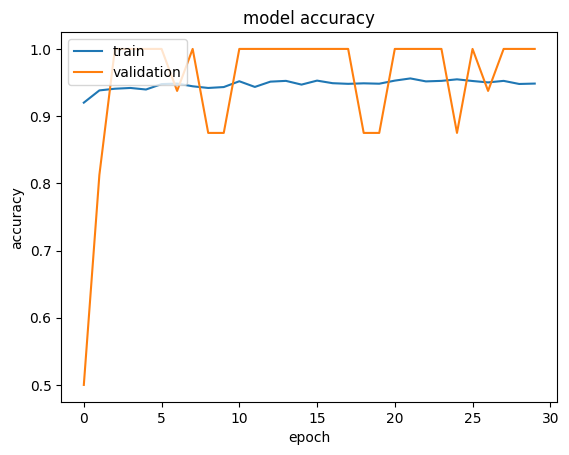

In [ ]:
plot_hist(hist)

The second step is to unfreeze a number of layers and fit the model using smaller
learning rate. In this example we show unfreezing all layers, but depending on
specific dataset it may be desireble to only unfreeze a fraction of all layers.

In [9]:
# We unfreeze the top 20 layers while leaving BatchNorm layers frozen
for layer in model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["binary_accuracy"])

epochs = 15 # @param {type:"slider", min:4, max:20, step:1}
hist = model.fit(ds_train,
                 epochs=epochs,
                 steps_per_epoch=ds_train.samples//ds_train.batch_size,
                 validation_data=ds_val,
                 validation_steps=ds_val.samples//ds_val.batch_size,
                 verbose=1)

Epoch 1/15
163/163 [==============================] - 170s 965ms/step - loss: 0.1308 - binary_accuracy: 0.9546 - val_loss: 0.1660 - val_binary_accuracy: 0.8750
Epoch 2/15
163/163 [==============================] - 156s 957ms/step - loss: 0.1354 - binary_accuracy: 0.9546 - val_loss: 0.0921 - val_binary_accuracy: 0.9375
Epoch 3/15
163/163 [==============================] - 155s 954ms/step - loss: 0.1207 - binary_accuracy: 0.9574 - val_loss: 0.0828 - val_binary_accuracy: 0.9375
Epoch 4/15
163/163 [==============================] - 156s 956ms/step - loss: 0.1204 - binary_accuracy: 0.9594 - val_loss: 0.0546 - val_binary_accuracy: 1.0000
Epoch 5/15
163/163 [==============================] - 156s 956ms/step - loss: 0.1135 - binary_accuracy: 0.9622 - val_loss: 0.0229 - val_binary_accuracy: 1.0000
Epoch 6/15
163/163 [==============================] - 156s 960ms/step - loss: 0.1167 - binary_accuracy: 0.9588 - val_loss: 0.0569 - val_binary_accuracy: 1.0000
Epoch 7/15
163/163 [====================

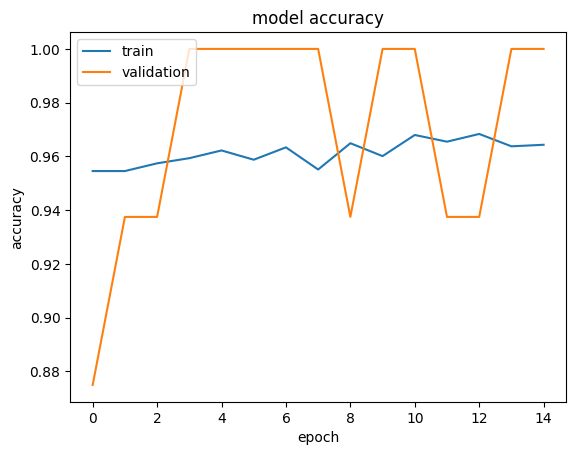

In [10]:
plot_hist(hist)

In [11]:
#Evaluate
result = model.evaluate(ds_test)
print(result)

# result = model.evaluate(ds_test, steps = len(df_test), verbose = 0)

print('Test loss:', result[0])
print('Test accuracy:', result[1])

20/20 [==============================] - 12s 402ms/step - loss: 0.4055 - binary_accuracy: 0.8670
[0.4054654836654663, 0.8669871687889099]
Test loss: 0.4054654836654663
Test accuracy: 0.8669871687889099
